In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

concentration_col = 'PriA-SSB Dose response: Concentration (uM)'
concentration_val = 33
ic50_col = 'PriA-SSB Dose response: IC50 (uM)'
median_inhib_col = 'Median % negative control (%)'
inhib_col = 'PriA-SSB Dose response: % negative control (%)'

res_full_df = pd.read_csv('../datasets/enamine_results/EnamineREAL_raw_dose_response_CDDcsvExport-2021-03-31-125137_cln.csv')
res_df = res_full_df[res_full_df[concentration_col] == concentration_val]
res_df = res_df[['Molecule Name', 'SMILES', 'Synonyms', concentration_col, inhib_col, ic50_col]]
res_df.index = res_df['Molecule Name'].tolist()
res_df[median_inhib_col] = 0
for smssf_id, row in res_df.groupby('Molecule Name').median().iterrows():
    res_df.loc[smssf_id, median_inhib_col] = row[inhib_col]
    res_df.loc[smssf_id, median_inhib_col] = row[inhib_col]
res_df = res_df.reset_index(drop=True)

assert res_df['Molecule Name'].unique().shape[0] == 68
assert res_df['Synonyms'].unique().shape[0] == 68

inhib_col = '% Inhibition'
hit_thresh = 50.0
res_df[inhib_col] = 100.0 - res_df[median_inhib_col]
res_df['Hit'] = (res_df[inhib_col] >= hit_thresh).astype(int)

res_df = res_df.rename({'Molecule Name' : 'SMSSF Molecule ID', 'Synonyms': 'ID Enamine', 'SMILES': 'SMSSF SMILES'}, axis=1)
w_df = pd.read_csv('../datasets/enamine_results/Enamine_IC50_wildman_potency_2021-03-12.csv')
w_df = w_df[['Molecule Name', 'Wildman Hit', 'Wildman Potency']]
w_df = w_df.rename({'Molecule Name' : 'SMSSF Molecule ID'}, axis=1)

res_df = res_df.merge(w_df, on='SMSSF Molecule ID')

res_df.to_csv('../datasets/enamine_results/pria_enamine_inhib.csv', index=False)

In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

hit_thresh = 50.0
concentration_val = 33
inhib_col = '% Inhibition'
ic50_col = 'PriA-SSB Dose response: IC50 (uM)'
median_inhib_col = 'Median % negative control (%)'

train_and_ams_df = pd.read_csv('../datasets/Zenodo/v1/train_ams_real_cluster.csv.gz')
train_and_ams_df = train_and_ams_df[train_and_ams_df['dataset'].isin(['train', 'ams'])]

cpd_info_df = pd.read_csv('../datasets/Zenodo/v1/enamine_final_list_v2.csv.gz').drop('Hit', axis=1)
res_df = pd.read_csv('../datasets/enamine_results/pria_enamine_inhib.csv')
res_df = res_df.drop_duplicates('SMSSF Molecule ID')

res_df = res_df.merge(cpd_info_df, on='ID Enamine')

top_real_clustering = pd.read_csv('../datasets/real_5629.csv.gz')

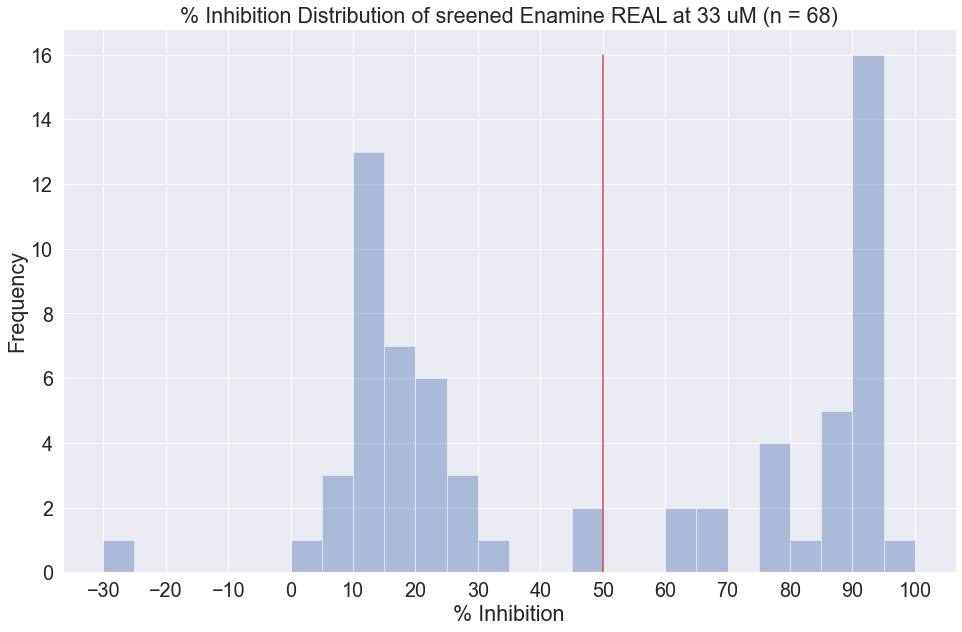

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(16, 10)

bin_range=[i for i in range(-30, 101) if i%5==0]
plt.figure(figsize=figsize)

sns.distplot(res_df[inhib_col], norm_hist=False, kde=False, bins=bin_range)
plt.plot([hit_thresh, hit_thresh], [0, 16], color='r')
plt.title('% Inhibition Distribution of sreened Enamine REAL at 33 uM (n = {})'.format(res_df.shape[0]))
plt.xlabel(inhib_col); plt.xticks([i for i in range(-30, 101) if i%10==0]); plt.ylabel('Frequency')
plt.show()

---
## Total Hits of Ordered Compounds

In [7]:
counts, hits = res_df.shape[0], res_df['Hit'].sum()
summary_df = pd.DataFrame(data=[[counts, hits, counts - hits, 100.0*(hits/counts)]],
                          columns=['Count', 'Hits', 'Misses', 'Hit Rate'], index=['RF-C Enamine REAL'])
summary_df

Count  Hits  Misses   Hit Rate
RF-C Enamine REAL     68    31      37  45.588235

In [14]:
res_df['Wildman Hit'].value_counts().to_frame().T

No  Hit  Unlikely  Possible
Wildman Hit  37   22         5         4

---
## Look at clusters/novel hits

Unique cluster hits counts the number of unique clusters with hits in the prospective dataset.

Novel cluster hits counts the number of unique clusters with hits that were NOT present in the training set. In other words, clusters that the model was not trained on. 

In [5]:
train_hits = train_and_ams_df[train_and_ams_df['Hit'] == 1]

cluster_cols = ['TB_0.4 ID']
cluster_summary = []
for df in [res_df]:
    ref_hits = df[df['Hit'] == 1]
    tmp_list = []
    for cluster_col in cluster_cols:
        cluster_hit_count = ref_hits[cluster_col].unique().shape[0]
        novel_cluster_count = np.setdiff1d(ref_hits[cluster_col].unique(), train_hits[cluster_col].unique()).shape[0]
        tmp_list.extend([cluster_hit_count, novel_cluster_count])
    cluster_summary.append(tmp_list)
cluster_hit_df = pd.DataFrame(data=cluster_summary,
                              columns=['Unique Cluster Hits (TB 0.4)', 'Novel Cluster Hits (TB 0.4)'],
                              index=['RF-C Enamine REAL'])
cluster_hit_df

Unique Cluster Hits (TB 0.4)  Novel Cluster Hits (TB 0.4)
RF-C Enamine REAL                            31                           31

In [6]:
summary_df = pd.concat([summary_df, cluster_hit_df], axis=1)
summary_df

Count  Hits  Misses   Hit Rate  \
RF-C Enamine REAL     68    31      37  45.588235   

                   Unique Cluster Hits (TB 0.4)  Novel Cluster Hits (TB 0.4)  
RF-C Enamine REAL                            31                           31

In [7]:
cols = ['Is Train cluster?', 'Is Train active cluster?', 
        'Is AMS cluster?', 'Is AMS active cluster?']

res_hits = res_df[res_df['Hit'] == 1]
for c in cols:
    print(c, res_hits[c].sum())
    
res_hits[(res_hits['Is Train cluster?'] == 1) | (res_hits['Is AMS cluster?'] == 1)].shape

Is Train cluster? 4
Is Train active cluster? 0
Is AMS cluster? 1
Is AMS active cluster? 0


(5, 34)

---
## Compound Structures

In [46]:
res_df['Wildman Hit']

0          Hit
1     Possible
2           No
3           No
4           No
        ...   
63          No
64          No
65          No
66          No
67         Hit
Name: Wildman Hit, Length: 68, dtype: object


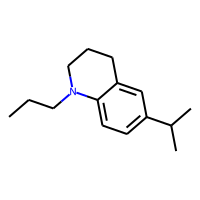
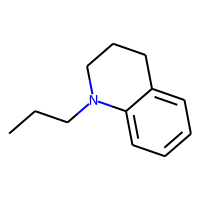
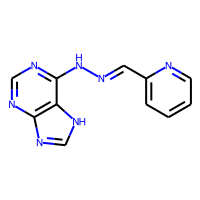
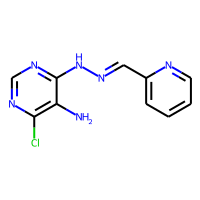
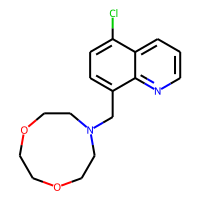
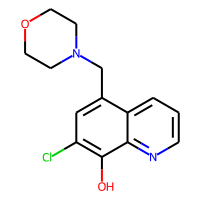
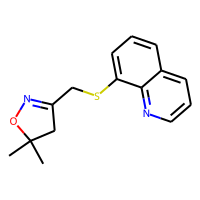
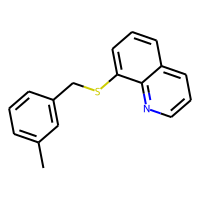
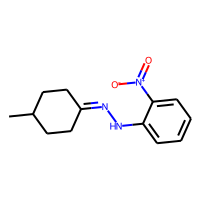
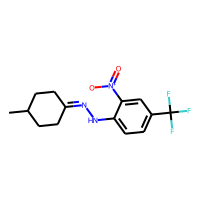
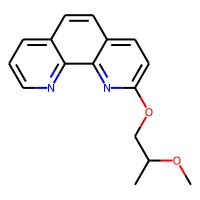
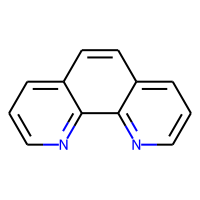
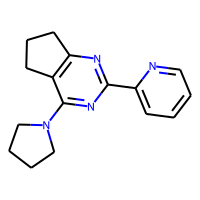
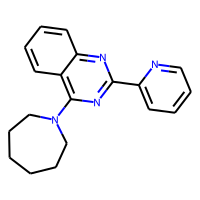
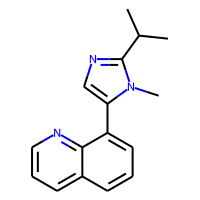
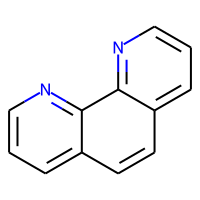
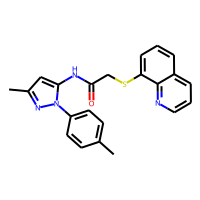
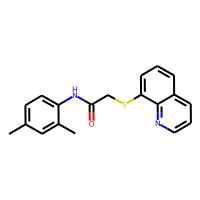
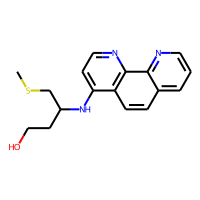
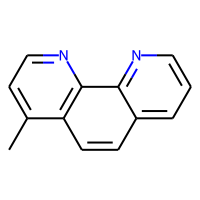
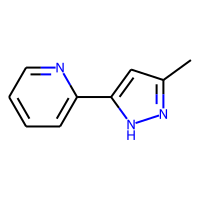
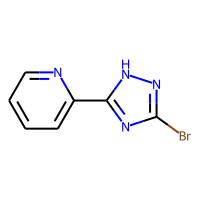
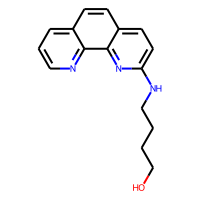
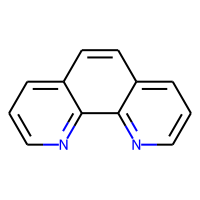
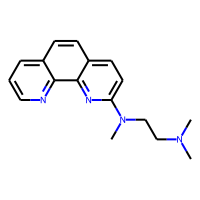
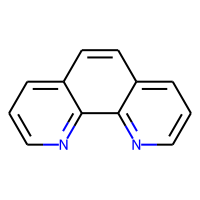
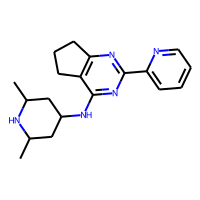
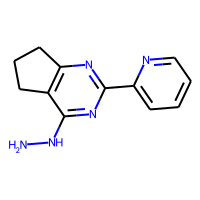
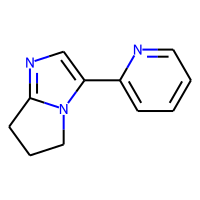
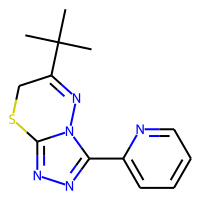
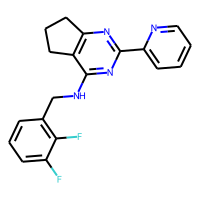
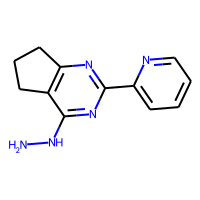
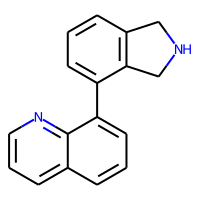
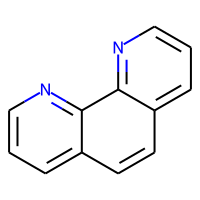
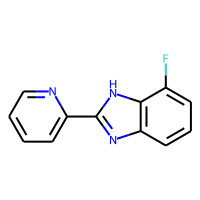
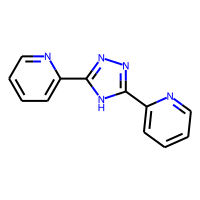
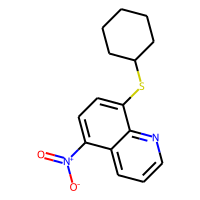
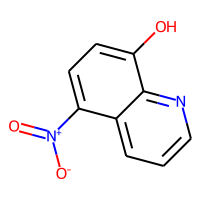
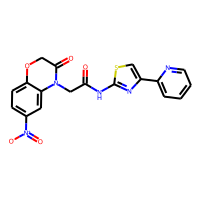
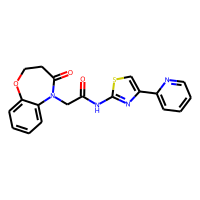
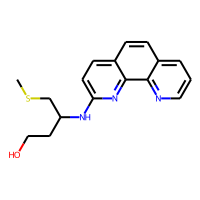
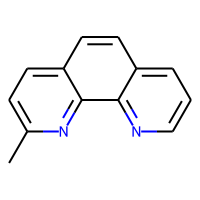
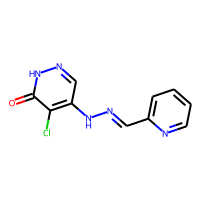
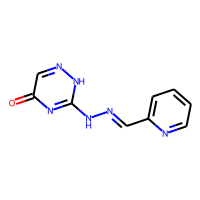
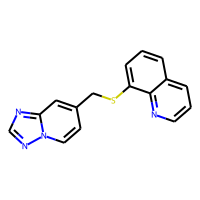
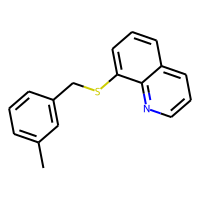
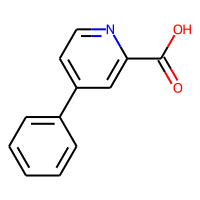
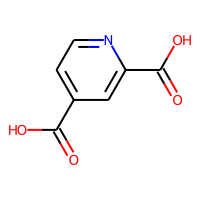
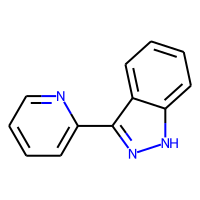
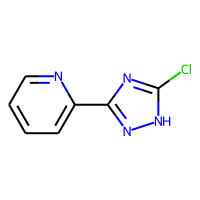
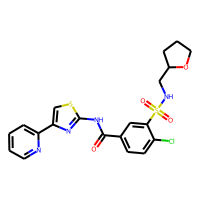
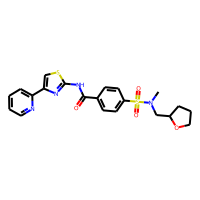
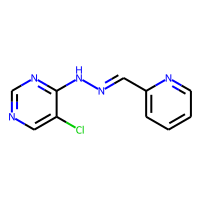
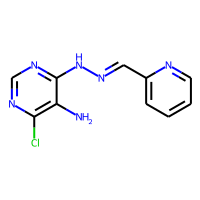
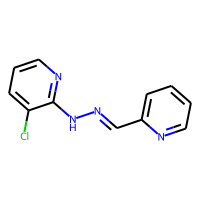
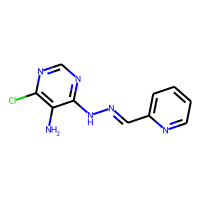
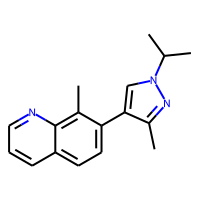
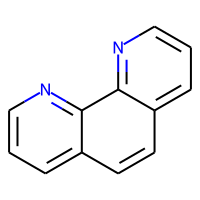
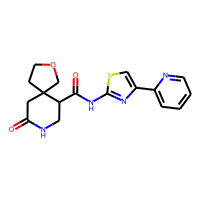
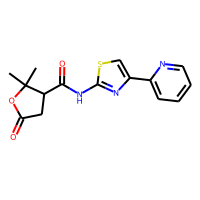
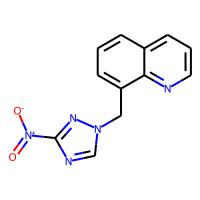
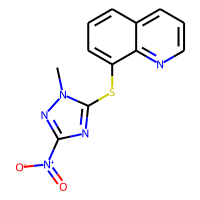
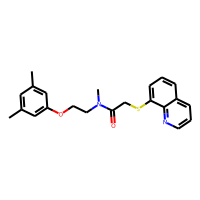
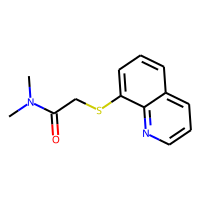
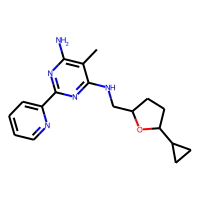
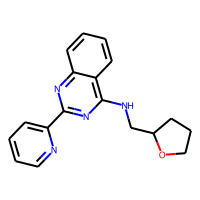
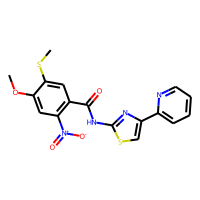
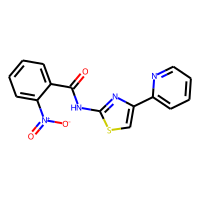
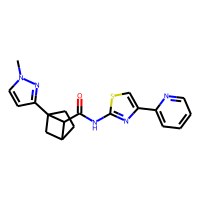
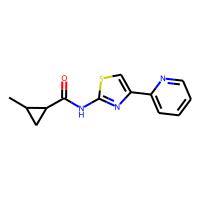
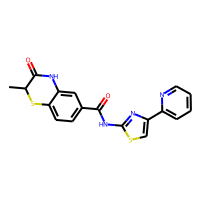
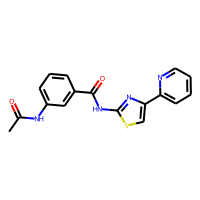
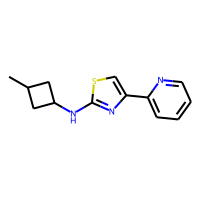
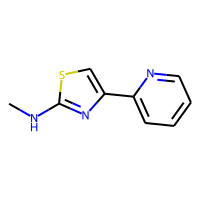
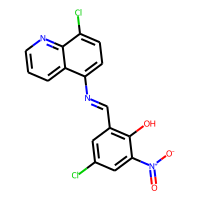
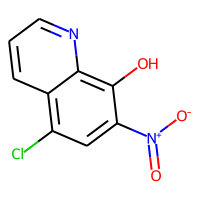
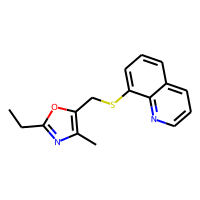
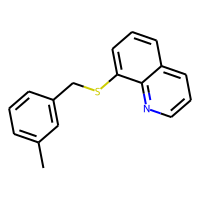
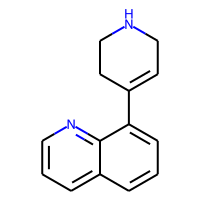
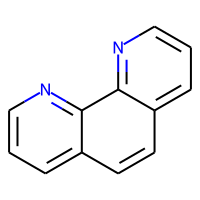
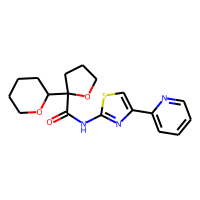
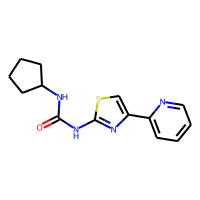
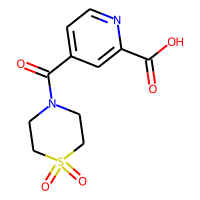
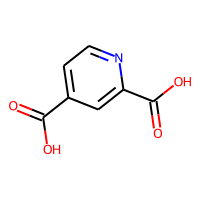
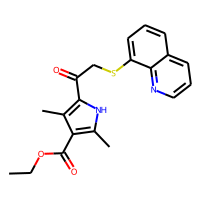
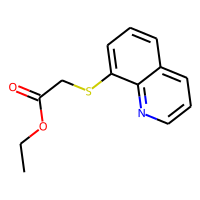
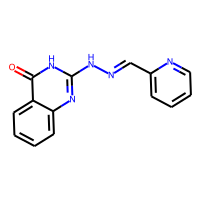
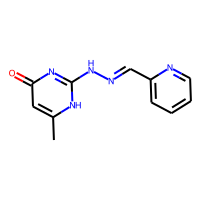
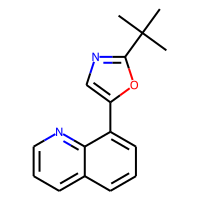
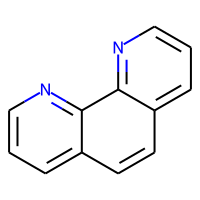
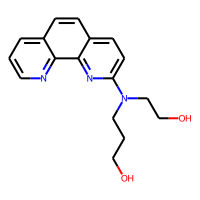
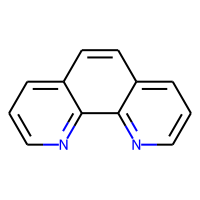
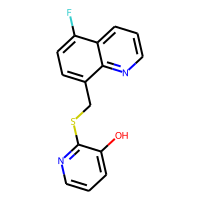
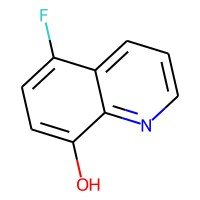
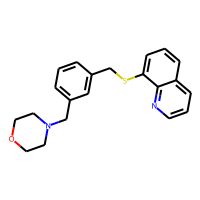
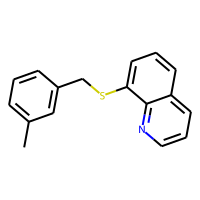
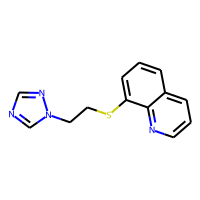
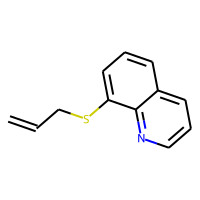
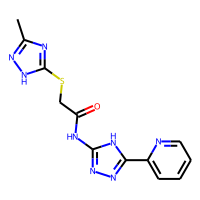
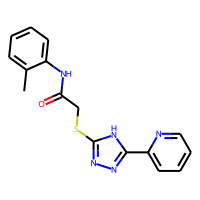
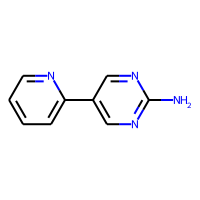
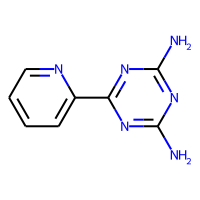
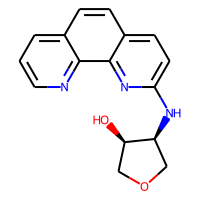
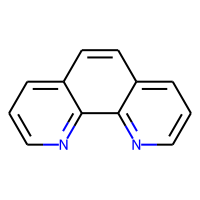
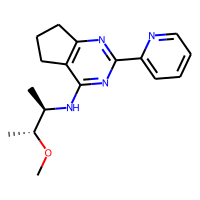
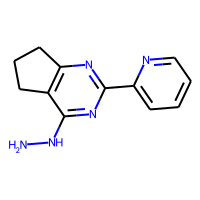
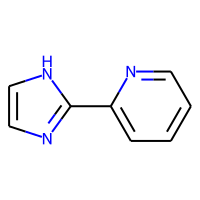
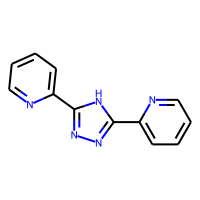
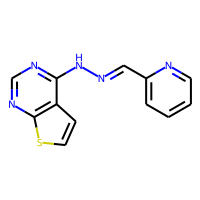
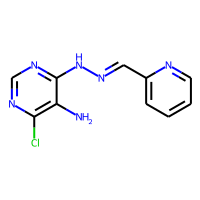
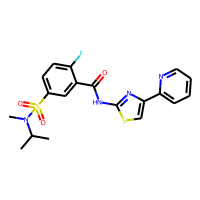
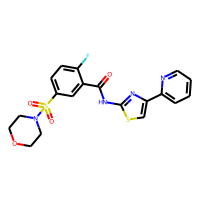
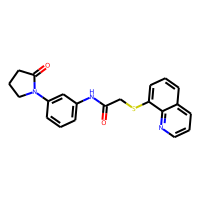
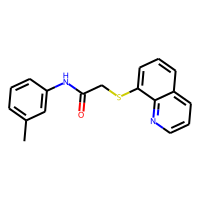
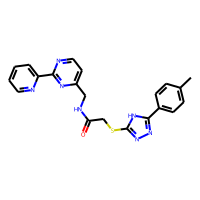
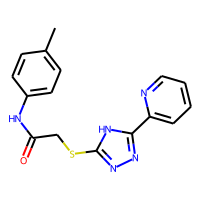
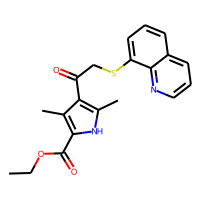
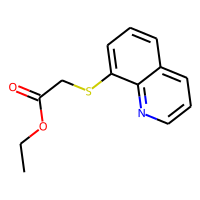
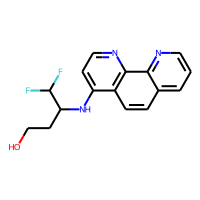
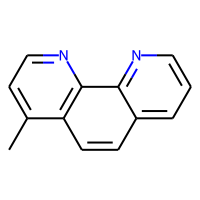
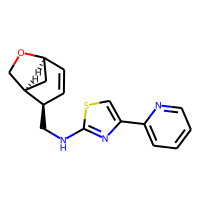
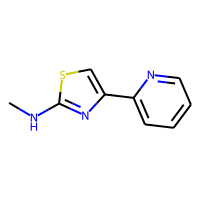
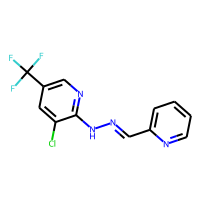
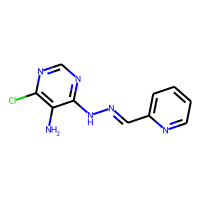
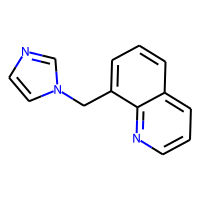
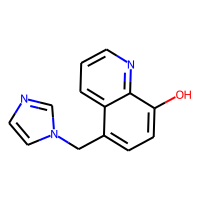
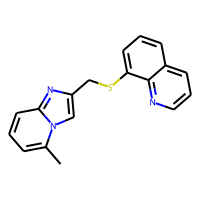
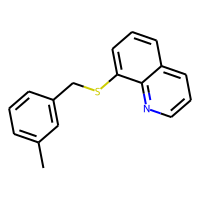
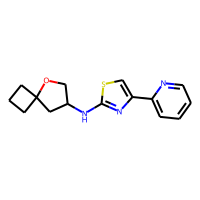
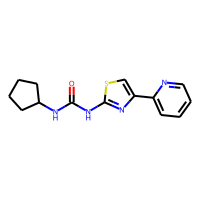
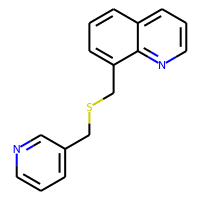
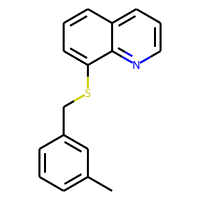
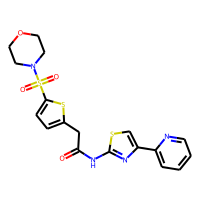
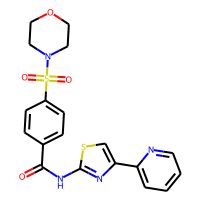
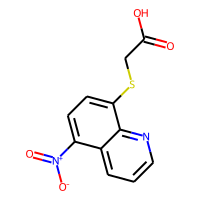
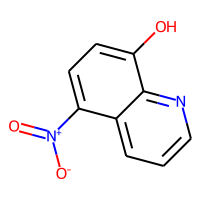

In [44]:
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import PandasTools
from IPython.core.display import HTML
from rdkit.Chem import AllChem
PandasTools.RenderImagesInAllDataFrames(images=True)
DrawingOptions.atomLabelFontSize = 55
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3.0
from rdkit.Chem import rdFMCS

molid_col = 'ID Enamine'
inhib_col = '% Inhibition'
ic50_col = 'PriA-SSB Dose response: IC50 (uM)'
median_inhib_col = 'Median % negative control (%)'

potency_dict = {'~1uM': 90, '1-5uM': 89, '2-6uM': 88, '5-10uM': 87, 
                '8-12uM': 86, '10-15uM': 85, '15-20uM': 84, '>20uM': 83, 
                'See SMSSF-0632575': 82, 'See SMSSF-0632551': 81, 
                'See SMSSF-0632554': 80, np.nan: 79}

res_df['Wildman Potency Order'] = 0
for i in range(res_df.shape[0]):
    res_df.loc[i, 'Wildman Potency Order'] = potency_dict[res_df.loc[i, 'Wildman Potency']]

def show(df): # see issue: https://github.com/rdkit/rdkit/issues/2673
    return HTML(df.to_html())

def get_sim_df(train_df, prosp_df):
    X_train_actives = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in train_df['1024 MorganFP Radius 2']]).astype(float)
    X_prosp = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in prosp_df['1024 MorganFP Radius 2']]).astype(float)
    train_prosp_tandist = pairwise_distances(X_prosp, X_train_actives, metric='jaccard')
    sim_info = []
    for i in range(train_prosp_tandist.shape[0]):
        prosp_smiles = prosp_df['rdkit SMILES'].iloc[i]; prosp_mol = Chem.MolFromSmiles(prosp_smiles);
        closest_active_idx = np.argmin(train_prosp_tandist[i,:]); 
        dist = train_prosp_tandist[i,closest_active_idx]
        train_smiles = train_df['rdkit SMILES'].iloc[closest_active_idx]; train_mol = Chem.MolFromSmiles(train_smiles);

        # try to align mols
        try:
            mcs = rdFMCS.FindMCS([train_mol, prosp_mol], ringMatchesRingOnly=True, completeRingsOnly=True)
            template = Chem.MolFromSmarts(mcs.smartsString)
            AllChem.Compute2DCoords(template, nSample=100, sampleSeed=20201337)
            AllChem.GenerateDepictionMatching2DStructure(train_mol, template)
            AllChem.GenerateDepictionMatching2DStructure(prosp_mol, template)
        except:
            pass
        
        dataset_name = train_df['dataset'].iloc[closest_active_idx]
        if dataset_name == 'train':
            dataset_name = 'Training'
        elif dataset_name == 'ams':
            dataset_name = 'AMS'
        dataset_dist = '{}: {:.2f}'.format(dataset_name, dist)
        
        is_hit = prosp_df['Wildman Hit'].iloc[i]
        if is_hit == 'Hit':
            is_hit = 1
        else:
            is_hit = 0
        sim_info.append((prosp_df[molid_col].iloc[i], prosp_mol, train_mol, dataset_dist, dist, is_hit, 
                         prosp_df[inhib_col].iloc[i], prosp_df['Wildman Potency'].iloc[i], 
                         prosp_df['Wildman Potency Order'].iloc[i]))
        
    sim_df = pd.DataFrame(data=sim_info, 
                          columns=['Mol ID', 'Prospective Mol', 'Nearest Training or AMS Active', 
                                   'Dataset:Tanimoto Distance',  'Tanimoto Distance', 'Is Hit?', 
                                   inhib_col, ic50_col, 'Wildman Potency Order'])
    sim_df = sim_df.sort_values(['Wildman Potency Order', inhib_col], ascending=False).reset_index(drop=True)
    sim_df = sim_df.drop('Wildman Potency Order', axis=1)
    return sim_df

train_ams_actives = train_and_ams_df[train_and_ams_df['Hit'] == 1]
res_hits_df = res_df[res_df['Wildman Hit'] == 'Hit']
sim_df = get_sim_df(train_ams_actives, res_df)
sim_hits_df = get_sim_df(train_ams_actives, res_hits_df)
show(sim_df)

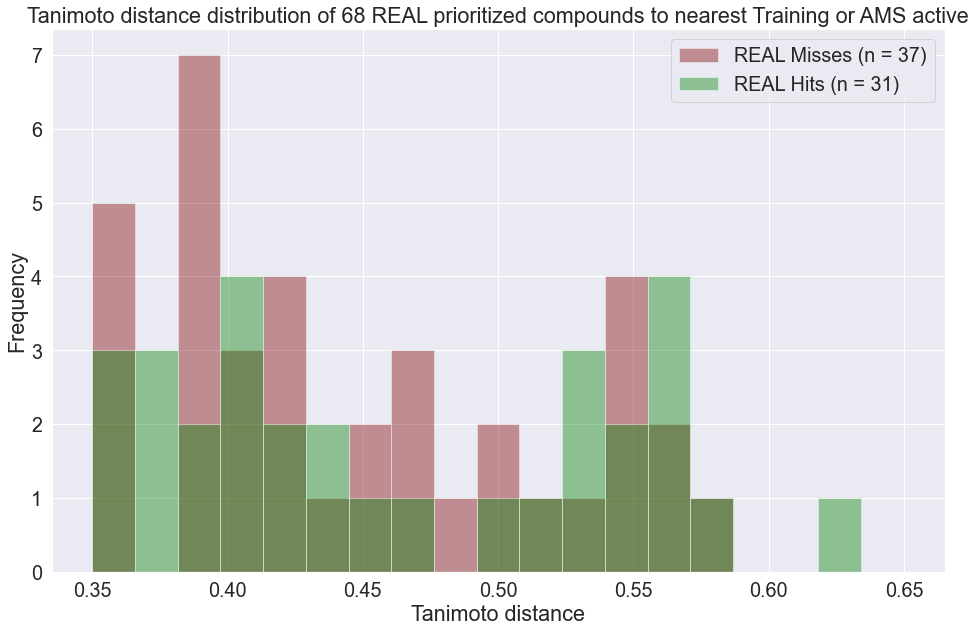

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(16, 10)

tan_dist = sim_df['Tanimoto Distance'].values
bin_range= np.linspace(0.35, 0.65, 20) #[0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65] #np.linspace(0.35, 0.65, 10)
plt.figure(figsize=figsize)
prosp_hits_dist = sim_df[sim_df['Is Hit?'] == 1]['Tanimoto Distance'].values
prosp_misses_dist = sim_df[sim_df['Is Hit?'] == 0]['Tanimoto Distance'].values

sns.distplot(prosp_misses_dist, bins=bin_range, norm_hist=False, kde=False, color='maroon')  
sns.distplot(prosp_hits_dist, bins=bin_range, norm_hist=False, kde=False, color='green')  
plt.title('Tanimoto distance distribution of 68 REAL prioritized compounds to nearest Training or AMS active')
plt.xlabel('Tanimoto distance'); plt.ylabel('Frequency');
plt.legend(['REAL Misses (n = {})'.format(prosp_misses_dist.shape[0]), 
            'REAL Hits (n = {})'.format(prosp_hits_dist.shape[0])])
plt.show()

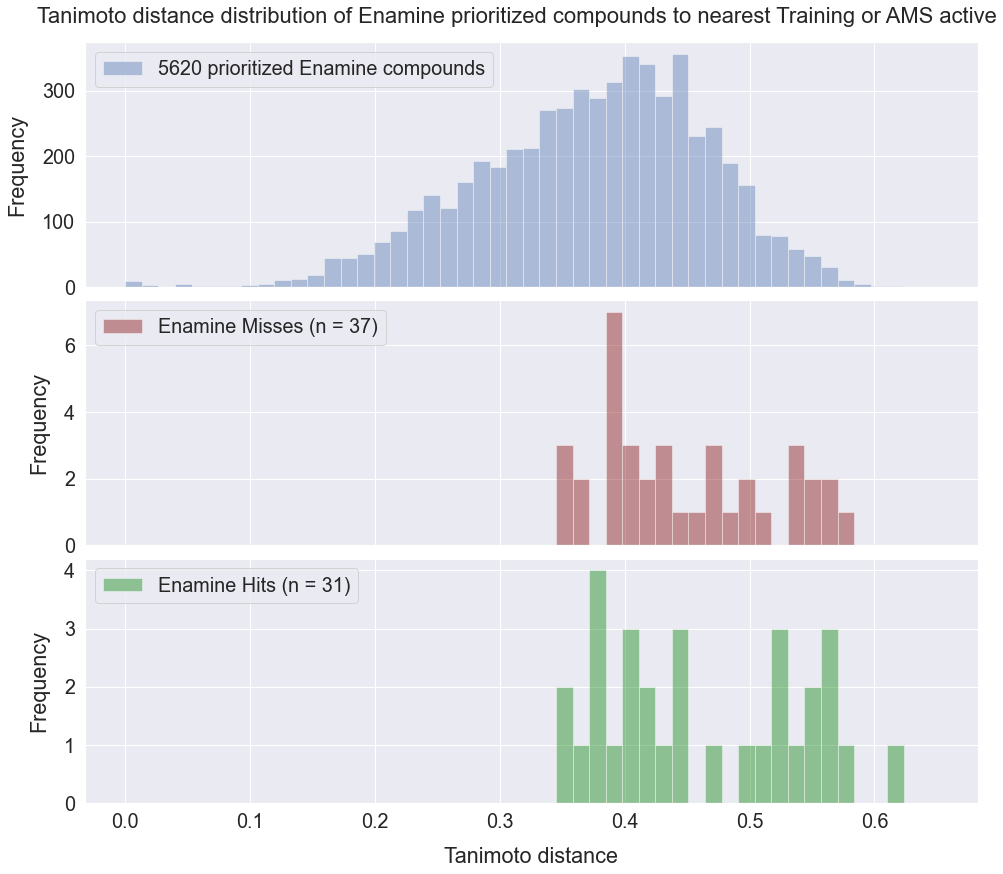

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(16, 14)

tan_dist = sim_df['Tanimoto Distance'].values
bin_range= np.linspace(0.0, 0.65, 50) 
prosp_hits_dist = sim_df[sim_df['Is Hit?'] == 1]['Tanimoto Distance'].values
prosp_misses_dist = sim_df[sim_df['Is Hit?'] == 0]['Tanimoto Distance'].values
legends = ['5620 prioritized Enamine compounds',
           'Enamine Misses (n = {})'.format(prosp_misses_dist.shape[0]), 
           'Enamine Hits (n = {})'.format(prosp_hits_dist.shape[0])]

fig, axes = plt.subplots(3,1, figsize=figsize, sharex=True)

#plt.title('Tanimoto distance distribution of 5620 purchaseable Enamine REAL\n compounds to nearest Training or AMS active')
tan_5620_dist = top_real_clustering[['Closest Train Active TanDist', 'Closest AMS Active TanDist']].min(axis=1).values
sns.distplot(tan_5620_dist, bins=bin_range, norm_hist=False, kde=False, ax=axes[0])  
sns.distplot(prosp_misses_dist, bins=bin_range, norm_hist=False, kde=False, ax=axes[1], color='maroon')
sns.distplot(prosp_hits_dist, bins=bin_range, norm_hist=False, kde=False, ax=axes[2],color='green')

for i, ax in enumerate(axes):
    #ax.set_xlim([0.35,0.65])
    #ax.set_ylim([0,9.5])
    #ax.set_xticks([int(i) for i in np.linspace(35, 165, 14)])
    ax.set_ylabel('Frequency', labelpad=15);
    ax.legend([legends[i]], loc='upper left')
    
plt.subplots_adjust(wspace=0, hspace=0.055)
plt.xlabel('Tanimoto distance', labelpad=15)
plt.suptitle('Tanimoto distance distribution of Enamine prioritized compounds to nearest Training or AMS active', 
             y=.915, fontsize=22)
plt.show()

---
## Similarity Heatmaps

Mol ID                                    Prospective Mol  \
0   PV-001918010086  <img data-content="rdkit/molecule" src="data:i...   
1       Z3638513333  <img data-content="rdkit/molecule" src="data:i...   
2         Z49571468  <img data-content="rdkit/molecule" src="data:i...   
3       Z3634004206  <img data-content="rdkit/molecule" src="data:i...   
4       Z1172208679  <img data-content="rdkit/molecule" src="data:i...   
5       Z2739840324  <img data-content="rdkit/molecule" src="data:i...   
6         Z71174619  <img data-content="rdkit/molecule" src="data:i...   
7       Z3557629872  <img data-content="rdkit/molecule" src="data:i...   
8       Z3225506284  <img data-content="rdkit/molecule" src="data:i...   
9       Z3558428795  <img data-content="rdkit/molecule" src="data:i...   
10      Z3557781825  <img data-content="rdkit/molecule" src="data:i...   
11      Z3395547714  <img data-content="rdkit/molecule" src="data:i...   
12      Z3347084877  <img data-content="rdkit/molecule" src="data:i...   
13  PV-001914484112  <img data-content="rdkit/molecule" src="data:i...   
14      Z3484513235  <img data-content="rdkit/molecule" src="data:i...   
15       Z666485712  <img data-content="rdkit/molecule" src="data:i...   
16  PV-002161956828  <img data-content="rdkit/molecule" src="data:i...   
17       Z109132782  <img data-content="rdkit/molecule" src="data:i...   
18      Z3557629875  <img data-content="rdkit/molecule" src="data:i...   
19       Z114886052  <img data-content="rdkit/molecule" src="data:i...   
20  PV-002140113355  <img data-content="rdkit/molecule" src="data:i...   
21      Z1741972899  <img data-content="rdkit/molecule" src="data:i...   

                       Nearest Training or AMS Active  \
0   <img data-content="rdkit/molecule" src="data:i...   
1   <img data-content="rdkit/molecule" src="data:i...   
2   <img data-content="rdkit/molecule" src="data:i...   
3   <img data-content="rdkit/molecule" src="data:i...   
4   <img data-content="rdkit/molecule" src="data:i...   
5   <img data-content="rdkit/molecule" src="data:i...   
6   <img data-content="rdkit/molecule" src="data:i...   
7   <img data-content="rdkit/molecule" src="data:i...   
8   <img data-content="rdkit/molecule" src="data:i...   
9   <img data-content="rdkit/molecule" src="data:i...   
10  <img data-content="rdkit/molecule" src="data:i...   
11  <img data-content="rdkit/molecule" src="data:i...   
12  <img data-content="rdkit/molecule" src="data:i...   
13  <img data-content="rdkit/molecule" src="data:i...   
14  <img data-content="rdkit/molecule" src="data:i...   
15  <img data-content="rdkit/molecule" src="data:i...   
16  <img data-content="rdkit/molecule" src="data:i...   
17  <img data-content="rdkit/molecule" src="data:i...   
18  <img data-content="rdkit/molecule" src="data:i...   
19  <img data-content="rdkit/molecule" src="data:i...   
20  <img data-content="rdkit/molecule" src="data:i...   
21  <img data-content="rdkit/molecule" src="data:i...   

   Dataset:Tanimoto Distance  Tanimoto Distance  Is Hit?  % Inhibition  \
0             Training: 0.41           0.410256        1        94.255   
1             Training: 0.47           0.469388        1        96.580   
2             Training: 0.35           0.354167        1        94.760   
3             Training: 0.53           0.529412        1        94.400   
4             Training: 0.41           0.409091        1        93.660   
5             Training: 0.58           0.583333        1        93.195   
6             Training: 0.37           0.372881        1        89.550   
7             Training: 0.56           0.562500        1        94.690   
8                  AMS: 0.54           0.542857        1        90.570   
9             Training: 0.53           0.529412        1        94.110   
10            Training: 0.50           0.500000        1        91.150   
11                 AMS: 0.38           0.375000        1        92.165   
12            Training: 0.62        
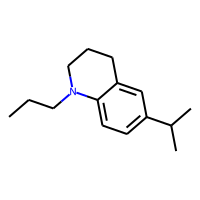
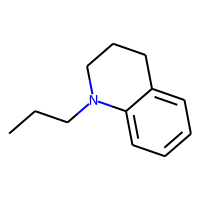
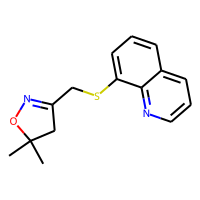
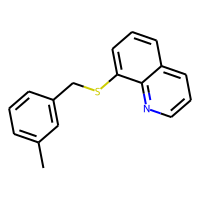
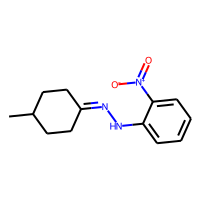
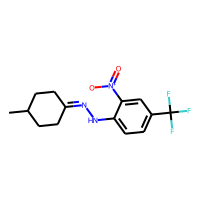
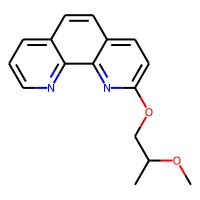
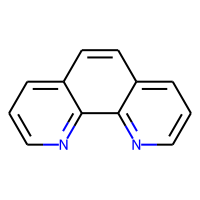
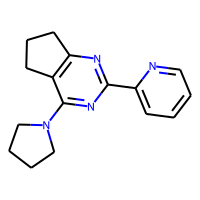
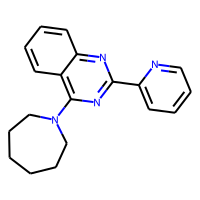
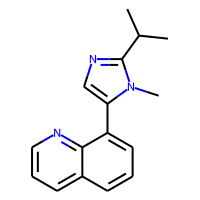
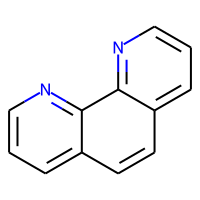
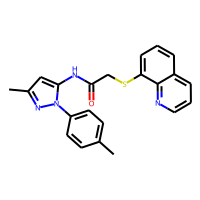
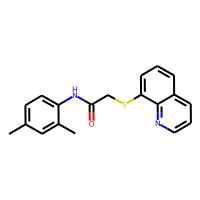
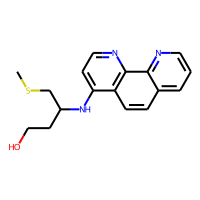
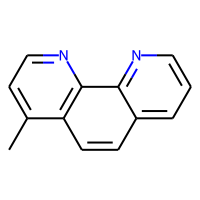
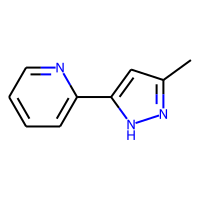
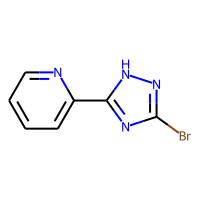
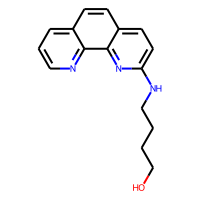
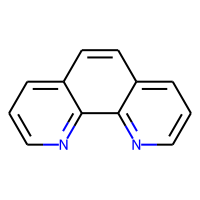
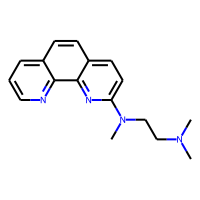
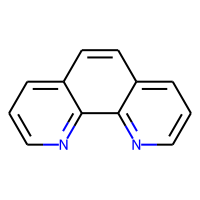
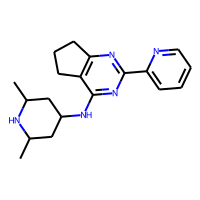
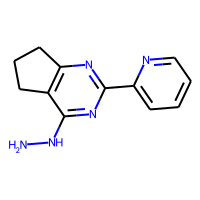
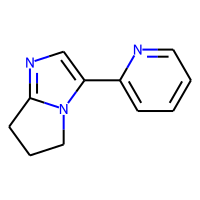
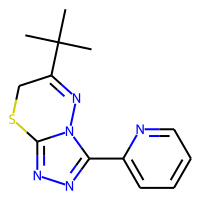
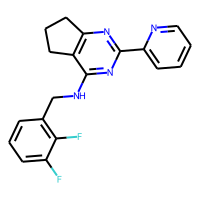
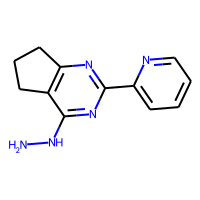
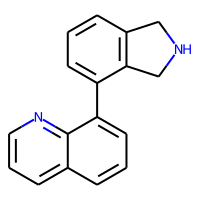
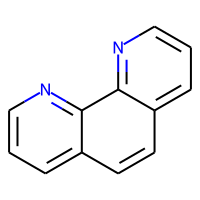
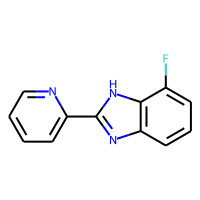
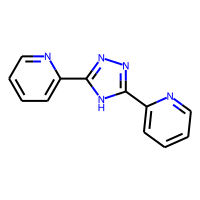
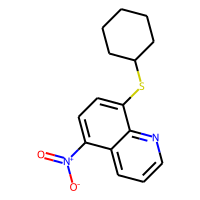
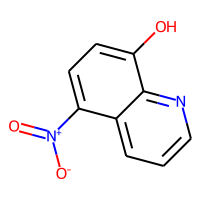
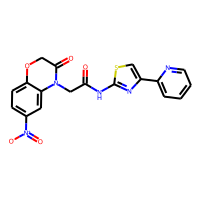
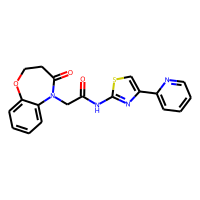
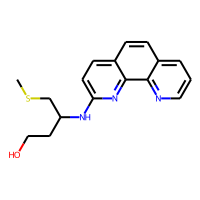
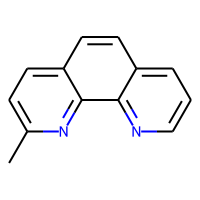
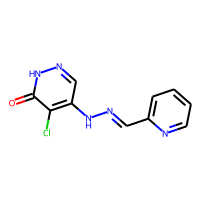
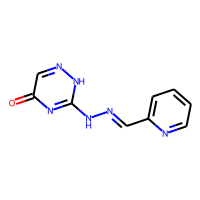
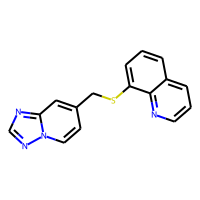
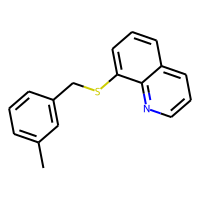
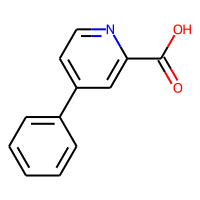
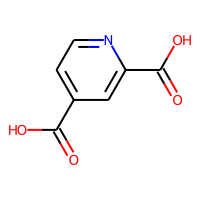

In [48]:
x

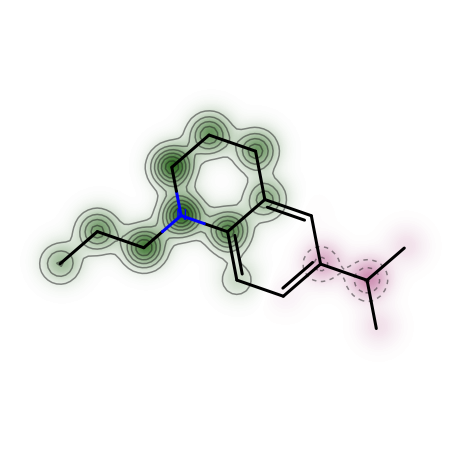

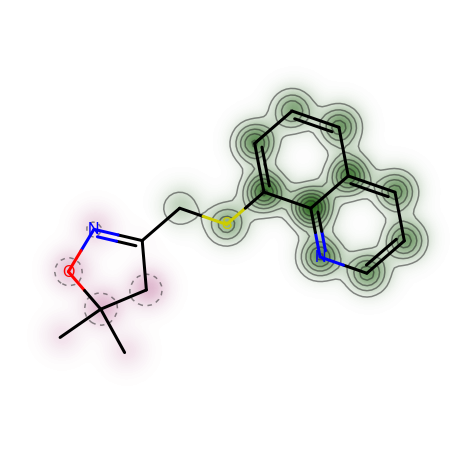

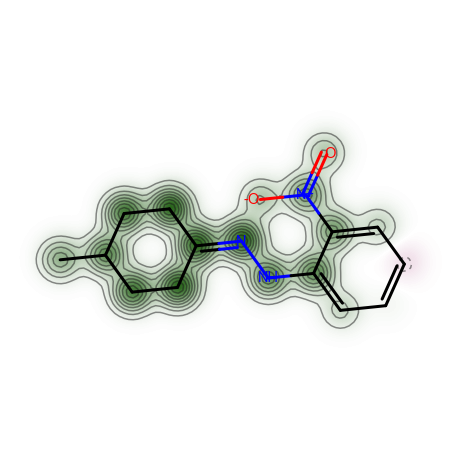

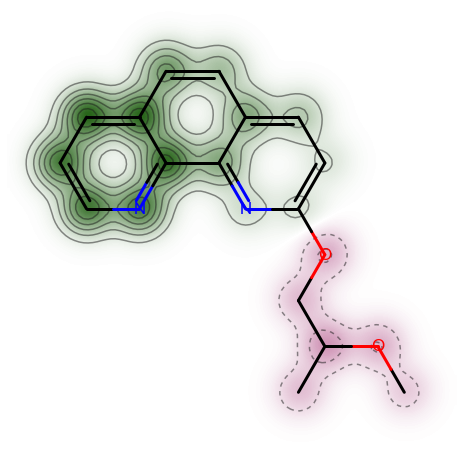

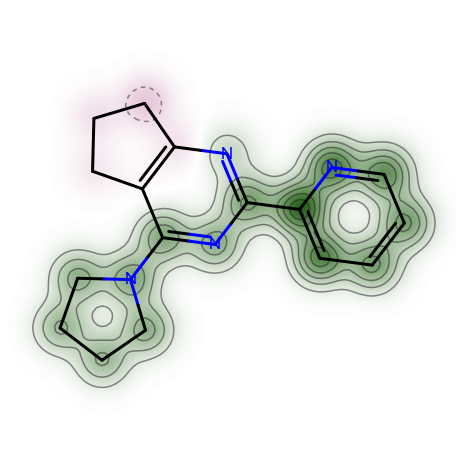

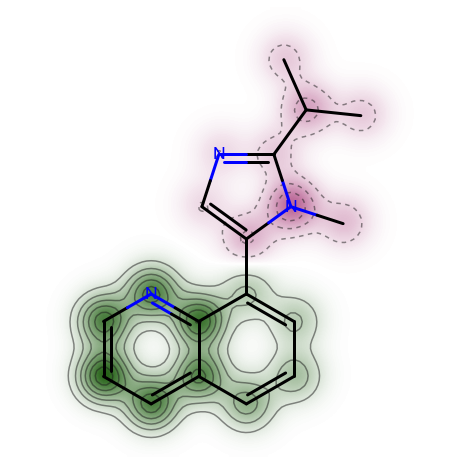

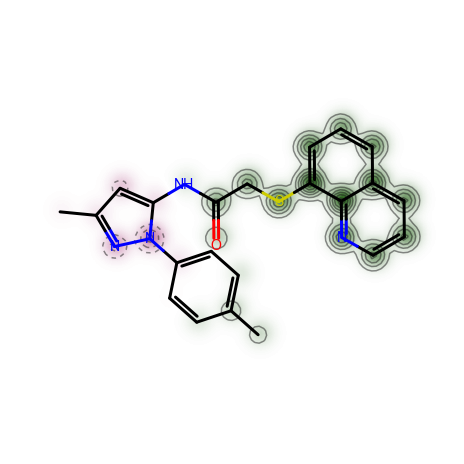

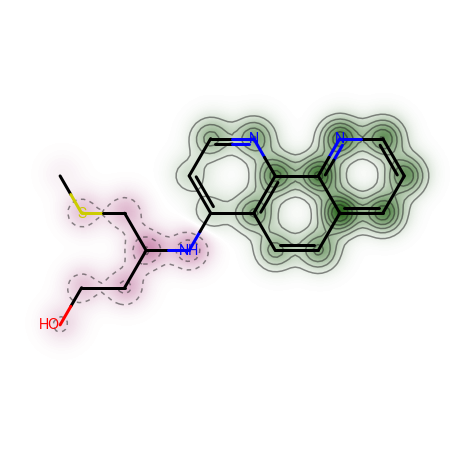

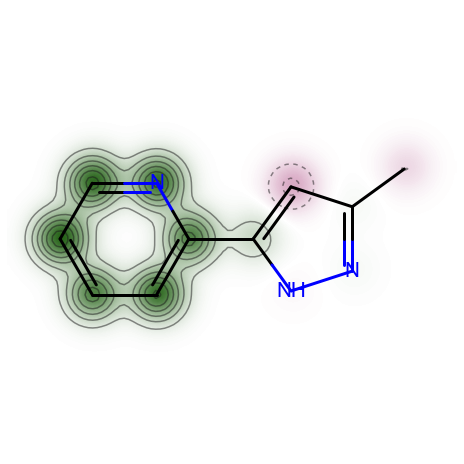

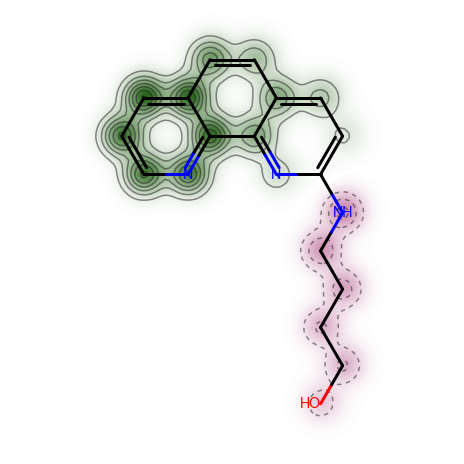

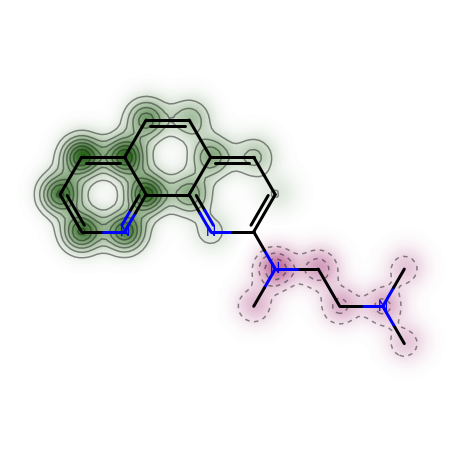

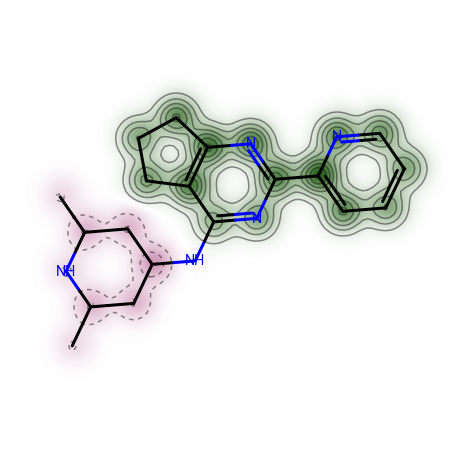

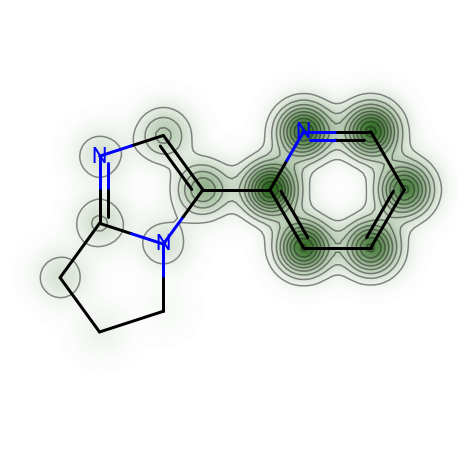

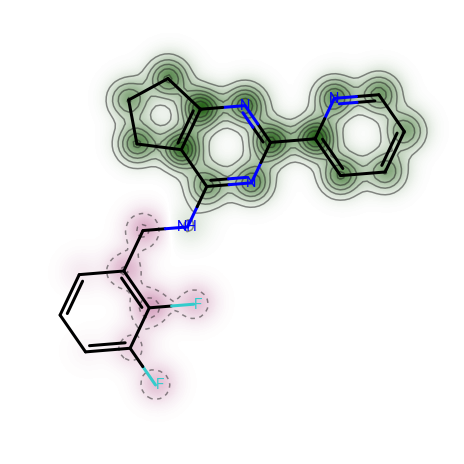

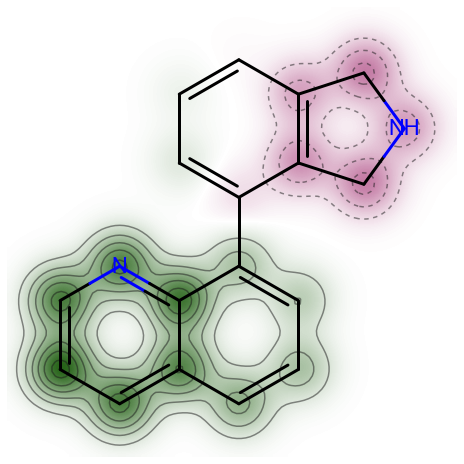

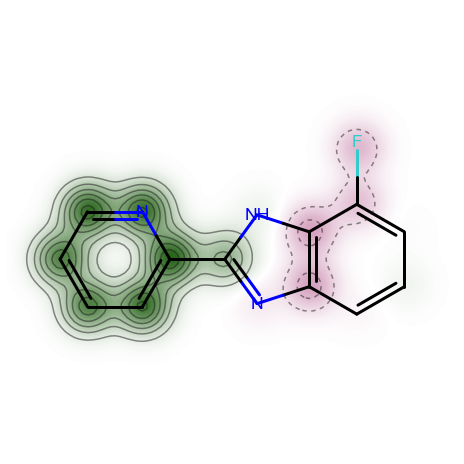

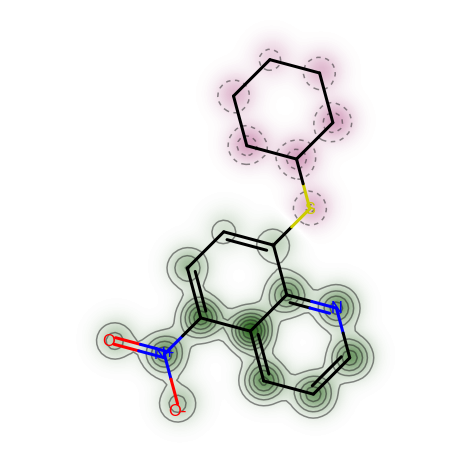

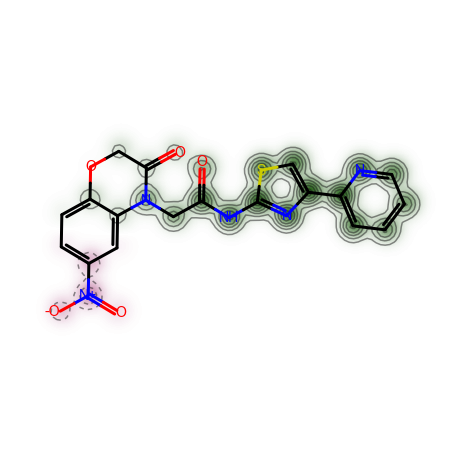

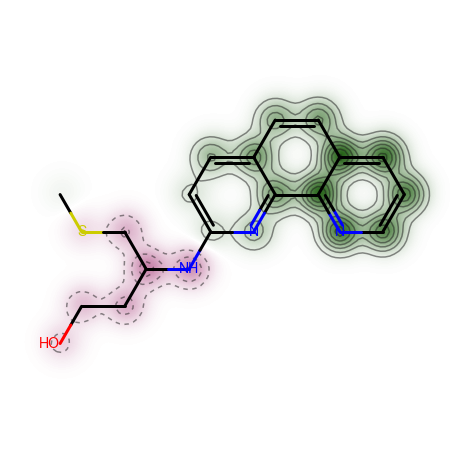

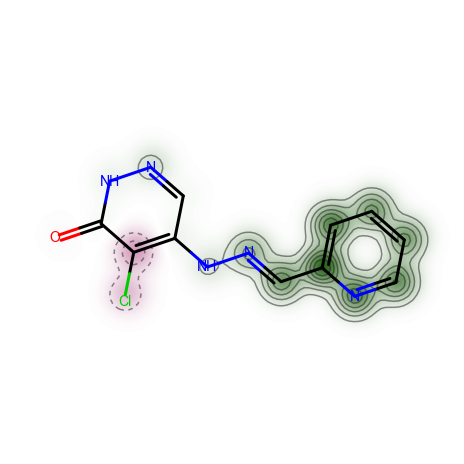

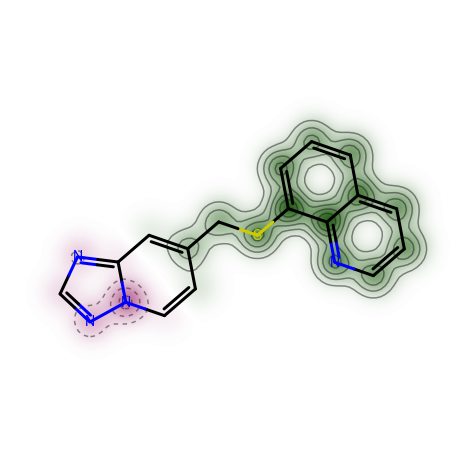

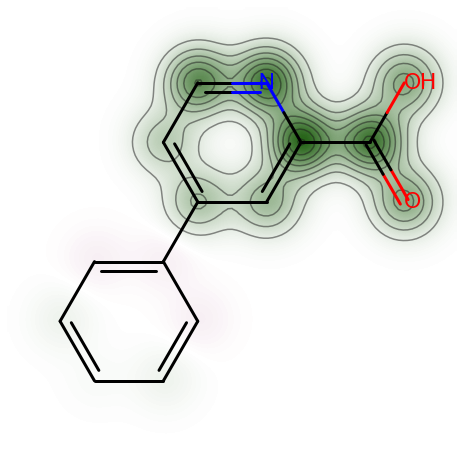

In [49]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Draw import SimilarityMaps
FP_radius=2
x = sim_hits_df.copy() #sim_df[sim_df['Is Hit?'] == 1]

for i in range(x.shape[0]):
    Draw.MolToFile(x.iloc[i,1], "./real_results_vis/rf_{}_{}.png".format(i, 'prosp'))
    Draw.MolToFile(x.iloc[i,2], "./real_results_vis/rf_{}_{}.png".format(i, 'train'))
    
    prosp_mol = x.iloc[i,1]
    train_mol = x.iloc[i,2]
    
    sim_func = (lambda a, b: SimilarityMaps.GetMorganFingerprint(a, atomId=b, fpType='bv', radius=FP_radius, nBits=1024))
    fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(train_mol, prosp_mol, sim_func)
        
    fig.savefig("./real_results_vis/rf_{}_{}.png".format(i, 'hmap'), bbox_inches='tight')

In [74]:
###### prefix = '\Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/'
image_fmt = 'rf_{}_{}'
row_fmt = '{} & {} & {} & {} & {} & {} \\\\'
sim_hits_df = sim_hits_df.round(2)

for i, row in sim_hits_df.iterrows():
    dataset_tandist = row['Tanimoto Distance']
    mol_id = '{\\footnotesize ' + row['Mol ID'] +'}'
    inhib_val = row[inhib_col]
    ic50_val = '\SI{' + row[ic50_col][:-2] +'}'+ row[ic50_col][-2:].replace('uM', '{\micro\metre}')
    x1 = prefix + image_fmt.format(i, 'prosp.png}')
    x2 = prefix + image_fmt.format(i, 'train.png}')
    x3 = prefix + image_fmt.format(i, 'hmap.png}')
    
    row_string = row_fmt.format(mol_id, x1, x2, x3, dataset_tandist, ic50_val)
    print(row_string)
    print('\\hline')

{\footnotesize PV-001918010086} & \Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_0_prosp.png} & \Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_0_train.png} & \Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_0_hmap.png} & 0.41 & \SI{~1}{\micro\metre} \\
\hline
{\footnotesize Z3638513333} & \Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_1_prosp.png} & \Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_1_train.png} & \Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_1_hmap.png} & 0.47 & \SI{2-6}{\micro\metre} \\
\hline
{\footnotesize Z49571468} & \Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_2_prosp.png} & \Includegraphics[trim=0cm 0cm 0cm 0cm,clip,width=0.15\linewidth]{figures/real/real_vis/rf_2_trai